{1: 563.6510916796877, 5: 378.5160516796873, 10: 193.3810116796874, 50: 41.50023137304686, 200: 16.773443526367185, 500: 9.95722706640625}
[41.47234335937498, 41.47234335937498, 41.47234335937498, 41.47234335937498, 39.74432905273436, 38.016314746093734]
[721.0081364746094, 412.0046494140625, 412.0046494140625, 412.0046494140625, 412.0046494140625, 515.0058117675782]


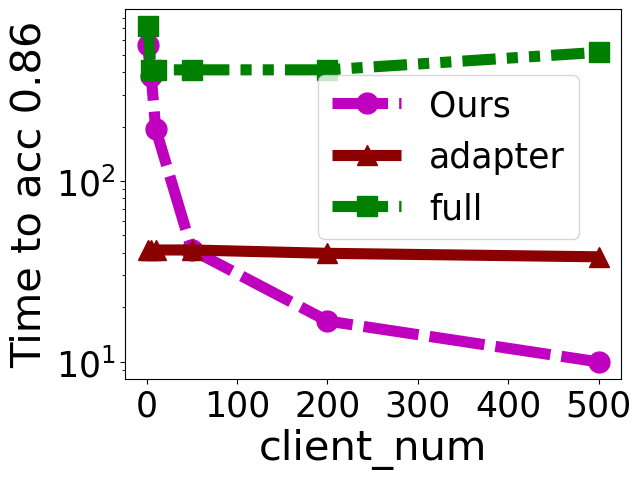

In [8]:
# figure 12

import os 
import sys
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

dataset = "agnews"
model = "distilbert"

train_time_dict = {"ours":0.3085584,"adapter":4.1634,"fedsgd":4.1634,"full":6.939}

local_data_num_dict = {"agnews":15,"yahoo":18}
comm_bandwidth = 10 * 1024**2 /8  # k * 1024**2 /8 => k Mb/s 

target_acc = 0.86
time_to_acc_dict ={}

eval_frequence = 5 if dataset == "yahoo" else 1
linestyle = [(0, ( )), (0, (3, 1,1,1,1,1)), (0, (4, 1,1,1)), (0, (1, 1)),(0, (2, 4)), (0, (5, 1)),(0,(3,1,3,1)),(0,(4,3,3,1))]*100
colors=['darkred','g','b','y','c','m','k',"tan"] * 100
lw = 8

def round_to_time(round,eval_frequence,comm_time,method,local_data_num,adhoc=None):
    train_time = train_time_dict[method]
    if adhoc == None:
        adhoc = [1,1,1]
    else:
        adhoc = list(map(int,adhoc.split(",")))
    time_list = [0]
    if method == "ours":
        time = (train_time*local_data_num*adhoc[0] + comm_time*local_data_num)/60
    # elif method == 'fedsgd':
    else:
        time = (train_time*local_data_num*adhoc[0] + 2*comm_time*local_data_num)/60
    # else:
    #     time = (train_time*local_data_num*adhoc[0] + 2*comm_time)/60
    time_list.append(time)
    for i in range(2,round):
        v_num = adhoc[i-1] if i-1 < len(adhoc) else adhoc[-1]
        if method == "ours":
            time += (train_time*local_data_num*v_num*eval_frequence + comm_time*local_data_num)/60
        # elif method == 'fedsgd':
        else:
            time += (train_time*local_data_num*v_num*eval_frequence + 2*comm_time*local_data_num)/60
        # else:
        #     time += (train_time*local_data_num*adhoc[0] + 2*comm_time)/60
        time_list.append(time)
    return time_list
    
def get_time_to_target_acc(target_acc,acc_list,time_list):
    n = len(acc_list)
    i = 0
    while i < n and acc_list[i] < target_acc:
        i += 1
    return time_list[i] if i<n else 10000

client_num_list = [1,5,10,50,200,500]
method = "ours"
time_to_acc_list = []
for i,client_num in enumerate(client_num_list):
    if client_num == 1:
        file = '/data/wyz/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/log/end2end/diff_client_num/distilbert_agnews/fedFwd_distilbert_agnews_lr0.01_client_num_1_numerical_muti_v300.log'
    else:
        file = f'./distilbert_agnews/fedFwd_distilbert_agnews_lr0.01_client_num_{client_num}_numerical_muti_v{1000//client_num}.log'
    local_data_num = local_data_num_dict[dataset]
    with open(file) as f:
        for line in f:
            if "Trainable" in line:
                param_num = int(line[line.rfind(":")+2:-2])
                break
        comm_time = param_num * 4 / comm_bandwidth
        acc = [0]
        adhoc = f'{1000//client_num},{1000//client_num},{1000//client_num}'
        if client_num == 1:
            adhoc = '300,300,300'
        max_acc = 0
        for line in f:
            if "'acc':" in line:
                cur_acc = float(line[line.rfind("'acc':")+7:line.rfind(",")])
                if cur_acc>max_acc:
                    max_acc = cur_acc
                else:
                    cur_acc = max_acc
                acc.append(cur_acc)
        time_list = round_to_time(len(acc),eval_frequence,comm_time,method,local_data_num,adhoc)
        time_to_acc_dict[client_num] = get_time_to_target_acc(target_acc,acc,time_list)
        time_to_acc_list.append(get_time_to_target_acc(target_acc,acc,time_list))
        # plt.plot(time_list, acc, linestyle=linestyle[i], color=colors[i],label=client_num,linewidth=lw)
print(time_to_acc_dict)

# plt.xlabel("Time",fontsize=20)
# plt.ylabel("Acc.",fontsize=20)
# plt.xticks(size = 20)
# plt.xlim(0,300)
# plt.yticks(size = 20)
# plt.ylim(0,0.98)
# plt.legend(fontsize=8)
# plt.title(f"{model} {dataset}",fontsize=30)
# plt.show()

plt.plot(client_num_list, time_to_acc_list, linestyle=linestyle[i], marker='o',markersize=15,color=colors[i],label='Ours',linewidth=lw)

new_client_num_list = [1,5,10,50,200,500]
method_list = ['adapter','full']

for i,method in enumerate(method_list):
    time_to_acc_list = []
    for client_num in new_client_num_list:
        # file = f'./distilbert_agnews/{method}_bert_agnews_lr0.01_client_num_{client_num}.log'
        file = f'/data/wyz/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/log/end2end/diff_client_num/distilbert_agnews/fedsgd_distilbert_agnews_lr0.01_client_num_{client_num}_{method}.log'
        local_data_num = local_data_num_dict[dataset]
        with open(file) as f:
            for line in f:
                if "Trainable" in line:
                    param_num = int(line[line.rfind(":")+2:-2])
                    break
            comm_time = param_num * 4 / comm_bandwidth
            acc = [0]
            adhoc = f'1,1,1'
            max_acc = 0
            for line in f:
                if "'acc':" in line:
                    cur_acc = float(line[line.rfind("'acc':")+7:line.rfind(",")])
                    if cur_acc>max_acc:
                        max_acc = cur_acc
                    else:
                        cur_acc = max_acc
                    acc.append(cur_acc)
                    if cur_acc>target_acc:
                        break
            time_list = round_to_time(len(acc),eval_frequence,comm_time,method,local_data_num,adhoc)
            # time_to_acc_dict[client_num] = get_time_to_target_acc(target_acc,acc,time_list)
            time_to_acc_list.append(get_time_to_target_acc(target_acc,acc,time_list))
    print(time_to_acc_list)
    marker_list = ['^','s']
    plt.plot(client_num_list, time_to_acc_list, linestyle=linestyle[i],marker=marker_list[i],markersize=15, color=colors[i],label=method,linewidth=lw)


# plt.xticks(range(len(time_to_acc_list)),client_num_list)
plt.xlabel("client_num",fontsize=30)
plt.ylabel(f"Time to acc {target_acc}",fontsize=30)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.yscale('log')
plt.legend(fontsize=25,loc=5,bbox_to_anchor=(0.95,0.6))
# plt.title(f"{model} {dataset}",fontsize=30)
# plt.show()
plt.savefig("/data/wyz/ForwardFL-Latex/figs/eval-e2e-clients.pdf",bbox_inches="tight")